# Data Importing

In [1]:
#Import The required Python libraries.
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from skimage import io, transform
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger,ProgbarLogger
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.regularizers import l2


**Changable_Parameter**

In [2]:
#here image size is 256x256
IMAGE_SIZE = 150
#every time process 32 images (61x31)~1951
BATCH_SIZE = 32
#how many color have in these pictures
CHANNELS = 3
#80x25~1951
EPOCHS = 25 #good at 12th
NUM_CLASSES = 2
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
patience=10
data_dir ="I:\\ai proj\\data"

model_name="MobileNetV2"  

In [3]:
import tensorflow as tf



# Define image parameters
img_height = IMAGE_SIZE
img_width = img_height
batch_size = BATCH_SIZE

# Define data augmentation parameters
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of the data will be used for validation
    rotation_range=60,  # Rotate images randomly up to 60 degrees (increased from 20)
    zoom_range=0.2,  # Zoom range [1-zoom_range, 1+zoom_range]
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,  # Flip images horizontally
    vertical_flip=True,  # Flip images vertically (added)
    fill_mode='nearest'  # Strategy used for filling in newly created pixels
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Update for multi-class classification
    subset='training'  # specify that this generator will be used for training data
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Update for multi-class classification
    subset='validation'  # specify that this generator will be used for validation data
)


Found 683 images belonging to 2 classes.
Found 170 images belonging to 2 classes.


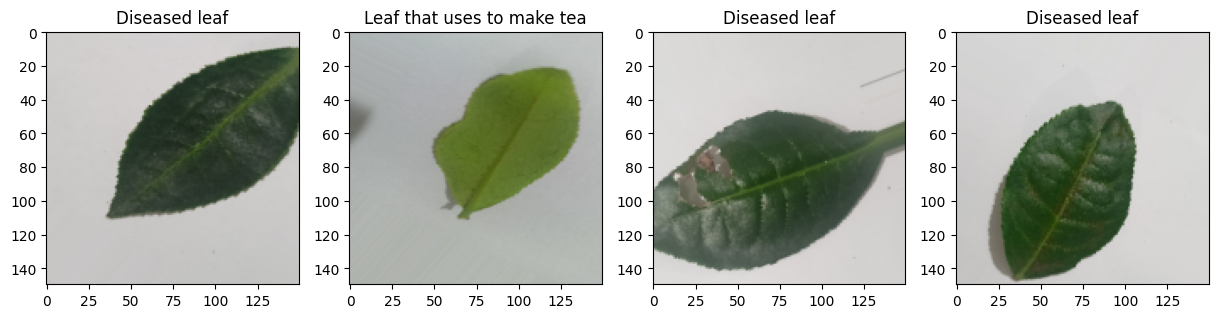

In [4]:
images, labels = next(train_generator)

# Plot four random images from the batch
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    # Generate a random index
    random_index = np.random.randint(0, BATCH_SIZE)
    
    # Plot the image
    axes[i].imshow(images[random_index])
    
    # Get the corresponding label
    label = labels[random_index]
    
    # Set the title as the class name
    class_name = train_generator.class_indices
    axes[i].set_title(list(class_name.keys())[np.argmax(label)])

plt.show()

# Building model

In [5]:
from tensorflow.keras.applications import EfficientNetV2B0,ResNet50,InceptionV3,NASNetMobile,EfficientNetV2L,DenseNet121,MobileNetV2

In [6]:
from tensorflow.keras.applications import EfficientNetV2B0,ResNet50,InceptionV3,NASNetMobile,EfficientNetV2L,DenseNet121,MobileNetV2

model= MobileNetV2(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
                 )

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in model.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 ReLU False
4 DepthwiseConv2D False
5 BatchNormalization False
6 ReLU False
7 Conv2D False
8 BatchNormalization False
9 Conv2D False
10 BatchNormalization False
11 ReLU False
12 ZeroPadding2D False
13 DepthwiseConv2D False
14 BatchNormalization False
15 ReLU False
16 Conv2D False
17 BatchNormalization False
18 Conv2D False
19 BatchNormalization False
20 ReLU False
21 DepthwiseConv2D False
22 BatchNormalization False
23 ReLU False
24 Conv2D False
25 BatchNormalization False
26 Add False
27 Conv2D False
28 BatchNormalization False
29 ReLU False
30 ZeroPadding2D False
31 DepthwiseConv2D False
32 BatchNormalization False
33 ReLU False
34 Conv2D False
35 BatchNormalization False
36 Conv2D False
37 BatchNormalization False
38 ReLU False
39 DepthwiseConv2D False
40 BatchNormalization False
41 ReLU False
42 Conv2D False
43 BatchNormalization False
44 Add False
45 Conv2D False
46 BatchNormalization False
47 ReLU False
48 DepthwiseCon

**Fine Tuning**

In [7]:
# # for layer in model.layers[:260]:
# #    layer.trainable = False
# # for layer in model.layers[260:]:
# #    layer.trainable = True

# # print('Last block of the conv_base is now trainable')


# for i, layer in enumerate(model.layers):
#    print(i, layer.name, layer.trainable)

In [8]:
def lw(bottom_model, num_classes):
    """Creates the top or head of the model that will be 
    placed on top of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.3)(top_model)  # Reduced dropout rate

    # Add more dense layers
    top_model = Dense(512, activation='relu')(top_model)  
    top_model = Dropout(0.3)(top_model)  # Reduced dropout rate

    # Add another dense layer
    top_model = Dense(256, activation='relu')(top_model)  
    top_model = Dropout(0.3)(top_model)  # Reduced dropout rate

    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model


In [9]:
from keras.models import Model
FC_Head = lw(model, NUM_CLASSES)
model = Model(inputs = model.input, outputs = FC_Head)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']           

# Training

In [10]:
from tensorflow.keras.callbacks import LearningRateScheduler


def scheduler(epoch, lr):
     if epoch < 10:
         return lr
     else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

In [11]:
if not os.path.exists("Results"):
    os.makedirs("Results")
if not os.path.exists("Model"):
    os.makedirs("Model") 
csv_logger_path = os.path.join("Results", f"{model_name}_results.csv")
model_checkpoint_path = os.path.join("Model", f"{model_name}_Model.hdf5")

**CheckPoints**

In [12]:

csv_logger = CSVLogger(csv_logger_path)
early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
check = ModelCheckpoint(model_checkpoint_path, verbose=1, save_best_only=True)
progbar_logger = ProgbarLogger()

In [13]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
history = model.fit(train_generator,
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    validation_data=validation_generator,
                    verbose = 1,
                    callbacks = [early_stopping,lr_scheduler,check,csv_logger],
                    initial_epoch=0)

Epoch 1/25
22/22 [==============================] - ETA: 0s - loss: 0.5753 - accuracy: 0.7731
Epoch 1: val_loss improved from inf to 0.24212, saving model to Model\MobileNetV2_Model.hdf5
22/22 [==============================] - 88s 4s/step - loss: 0.5753 - accuracy: 0.7731 - val_loss: 0.2421 - val_accuracy: 0.8882 - lr: 0.0010
Epoch 2/25
22/22 [==============================] - ETA: 0s - loss: 0.3344 - accuracy: 0.8682
Epoch 2: val_loss improved from 0.24212 to 0.14848, saving model to Model\MobileNetV2_Model.hdf5
22/22 [==============================] - 83s 4s/step - loss: 0.3344 - accuracy: 0.8682 - val_loss: 0.1485 - val_accuracy: 0.9529 - lr: 0.0010
Epoch 3/25
22/22 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.9327
Epoch 3: val_loss did not improve from 0.14848
22/22 [==============================] - 78s 4s/step - loss: 0.1678 - accuracy: 0.9327 - val_loss: 0.1541 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 4/25
22/22 [==============================] - ETA

# Result

In [14]:
#22th 24 epochs good

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

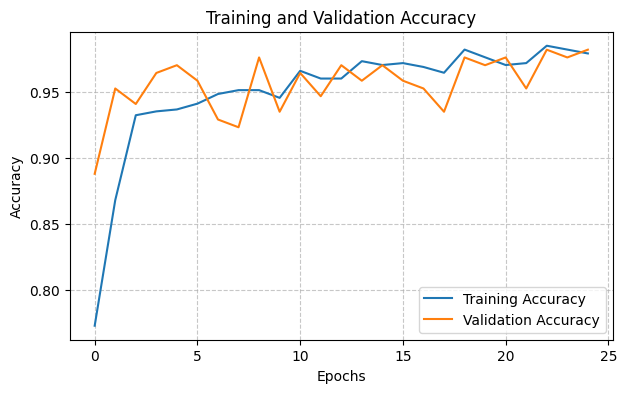

In [15]:

plt.figure(figsize=(7, 4))
plt.plot((epochs ), history.history['accuracy'], label='Training Accuracy')
plt.plot((epochs ), history.history['val_accuracy'], label='Validation Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

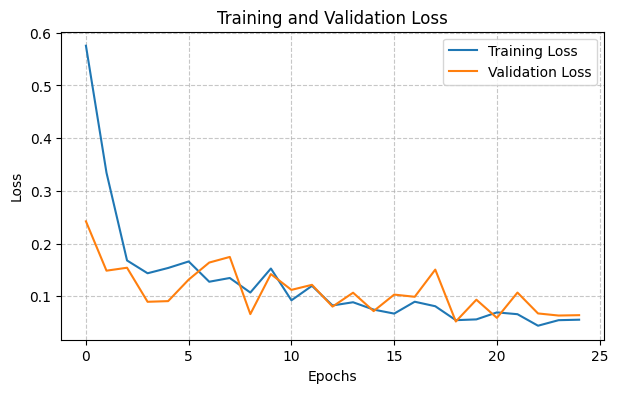

In [16]:
plt.figure(figsize=(7, 4))
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
        

In [17]:
score = model.evaluate(validation_generator ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

6/6 [==============================] - 17s 3s/step - loss: 0.0658 - accuracy: 0.9824
Test Loss: 0.06575816869735718
Test accuracy: 98.23529124259949


In [18]:
import numpy as np
from sklearn.metrics import classification_report


pred = model.predict(validation_generator)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(pred, axis=1)

# Get the true labels from the validation generator
true_labels = validation_generator.classes

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Compute the classification report with zero_division parameter set to 'warn'
report = classification_report(true_labels, predicted_labels, target_names=class_labels, zero_division=1)

print("Classification Report:")
print(report)


6/6 [==============================] - 20s 3s/step
Classification Report:
                            precision    recall  f1-score   support

             Diseased leaf       0.58      0.59      0.59        98
Leaf that uses to make tea       0.43      0.42      0.42        72

                  accuracy                           0.52       170
                 macro avg       0.50      0.50      0.50       170
              weighted avg       0.52      0.52      0.52       170



<Figure size 1200x1200 with 0 Axes>

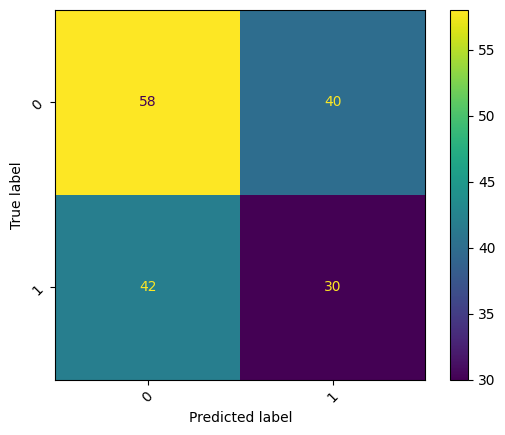

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix with adjusted figure size
plt.figure(figsize=(12, 12))  # Adjust the figure size as needed
disp.plot()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=45)  # Rotate y-axis labels for better readability
plt.show()


In [20]:
# target_names = []
# y_pred = model.predict(validation_generator).argmax(axis=1)
# for key in validation_generator.class_indices:
#     target_names.append(key)

# #print(target_names)

# from sklearn.metrics import classification_report

# # Compute the classification report with zero_division parameter set to 'warn'
# report = classification_report(validation_generator.classes, y_pred, target_names=target_names, zero_division=1)

# print('Classification Report:')
# print(report)
